In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import timeit
import time
import seaborn as sns

### Different experiment, where we are setting the emissions for the model to compute the change in temperature

In [2]:
# DICE manual 2010 - 2100, CO2 concentrations 400ppm to 850ppm
# FAIR is in GTCO2
# 12/44 GtC/GtCO2 epsilon_2
# Forcings work with carbon mass, so we need to convert
# 5.15 GtCO2 per 1 ppm
# (12/44)**-1 = 3.667
# 1 ppm = 2.13 GtC
# 1 ppm = 7.82 GtCO2
# 400ppm = 2.13*400 = 852 GtC
# DICE starts with 851 GtC

CMIP6 (IPCC report from 2021) emission projections https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_SPM_final.pdf
Data obtained from https://catalogue.ceda.ac.uk/uuid/98af2184e13e4b91893ab72f301790db?jump=related-docs-anchor

Description:
Panel (a): Global surface temperature changes in °C relative to 1850–1900. These changes were obtained by combining CMIP6 model simulations with observational constraints based on past simulated warming, as well as an updated assessment of equilibrium climate sensitivity.

CMIP5 (IPCC report from 2015)

In [3]:
# Read the CO2 forcings from the SSP file
basepath = Path.cwd()

In [4]:
#choose scenario
scenarios = ['ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585']
CMIP = dict()
for scenario in scenarios:
    data = pd.read_csv(basepath.joinpath(f'SSPs/{scenario}_FAIR.csv'))
    data_CMIP = pd.read_csv(basepath.joinpath(f'SSPs/{scenario}_CMIP.csv'))
    data_FAIR = pd.read_csv(basepath.joinpath(f'SSPs/{scenario}_FAIR.csv'))

    #take only every 5th value
    tas_CMIP = data_CMIP.tas_mean[::5].values
    tas_CMIP_lower = data_CMIP.tas_5[::5].values
    tas_CMIP_upper = data_CMIP.tas_95[::5].values
    CMIP[scenario] = [tas_CMIP, tas_CMIP_lower, tas_CMIP_upper]

In [5]:
from rice import Rice
import numpy as np
from itertools import product

rice_env = Rice()
rice_env.reset()
total_actions = rice_env.total_possible_actions
regions = list(range(rice_env.num_regions))
all_results = list()

class RiceAction:
    def __init__(self, dict):
        self.actions = np.zeros(len(total_actions))

        for k, v in dict.items():
            start_idx = rice_env.get_actions_index(k)
            end_idx = start_idx + rice_env.get_actions_len(k)
            self.actions[start_idx:end_idx] = v

env_vars = [
    "global_temperature",
#    "global_carbon_mass",
#    "global_exogenous_emissions",
#    "global_land_emissions",
#    "global_alpha",
#    "global_cumulative_emissions",
#    "global_cumulative_land_emissions",
#    "global_acc_pert_carb_stock",
]

economy_vars = [
    "gross_output_all_regions",
    #"capital_all_regions",
    #"aggregate_consumption",
    # "abatement_cost_all_regions",
    #"utility_all_regions",
    #"damages_all_regions",
]

tracked_vars = env_vars + economy_vars

# and doesn't this correspond to mitigation rates of 50% and 100%
MITIGATION_RATES = [0,4,7]
# dont we also need to set savings as 2?
SAVINGS_RATE = 2.5
# All scaled by /10


def run_simulations(env, carbon_model, dmg_function, temperature_calibration):
    data = []
    env.reset()
    for mitigation_rate in MITIGATION_RATES:
        # Get initial state
        for var in tracked_vars:
            val = env.get_state(var)
            if var == "global_temperature":
                val = val[0]
            elif var == "global_carbon_mass":
                val = val[0]
            elif var in ["gross_output_all_regions", "capital_all_regions", "aggregate_consumption", "utility_all_regions"]:
                val = np.sum(val).item()
            elif var == "damages_all_regions":
                val = np.mean(val)
            
            data.append({
                "Mitigation rate": mitigation_rate,
                "Savings rate": SAVINGS_RATE,
                "Value": val,
                "Variable": var,
                "Carbon model": carbon_model,
                "temperature_calibration": temperature_calibration,
                "dmg_function": dmg_function,
                "Timestep": 0,
            })
        
        # Run simulation
        while True:
            ind_actions = RiceAction({
                "savings": SAVINGS_RATE,
                "mitigation_rate": mitigation_rate
            }).actions
            # import bids
            # import tariffs
            # export limit
            # all 0

            actions = {region_id: ind_actions for region_id in regions}
            obs, rew, done, truncated, info = env.step(actions)
            if done["__all__"]:
                env.reset()
                break

            current_timestep = env.current_timestep
            for var in tracked_vars:
                val = env.get_state(var)

                if var == "global_temperature":
                    val = val[0]
                elif var == "global_carbon_mass":
                    val = val[0]
                elif var in ["gross_output_all_regions", "capital_all_regions", "aggregate_consumption", "utility_all_regions"]:
                    val = np.sum(val).item()
                elif var == "damages_all_regions":
                    val = np.mean(val)

                data.append({
                    "Mitigation rate": mitigation_rate,
                    "Savings rate": SAVINGS_RATE,
                    "Value": val,
                    "Variable": var,
                    "Carbon model": carbon_model,
                    "temperature_calibration": temperature_calibration,
                    "dmg_function": dmg_function,
                    "Timestep": current_timestep,
                })
    return data

for dmg_function, carbon_temp in product(["base", "updated"], ["base", "AR5", "FaIR", "FaIR calibrated"]):
    if carbon_temp != "FaIR calibrated":
        carbon_model = carbon_temp
        temperature_calibration = "base"
    else:
        carbon_model = "FaIR"
        temperature_calibration = "FaIR"
    rice = Rice(dmg_function=dmg_function, carbon_model=carbon_model, temperature_calibration=temperature_calibration)
    results_data = run_simulations(rice, carbon_model=str(carbon_model), dmg_function=str(dmg_function), temperature_calibration=str(temperature_calibration))
    all_results = all_results + results_data

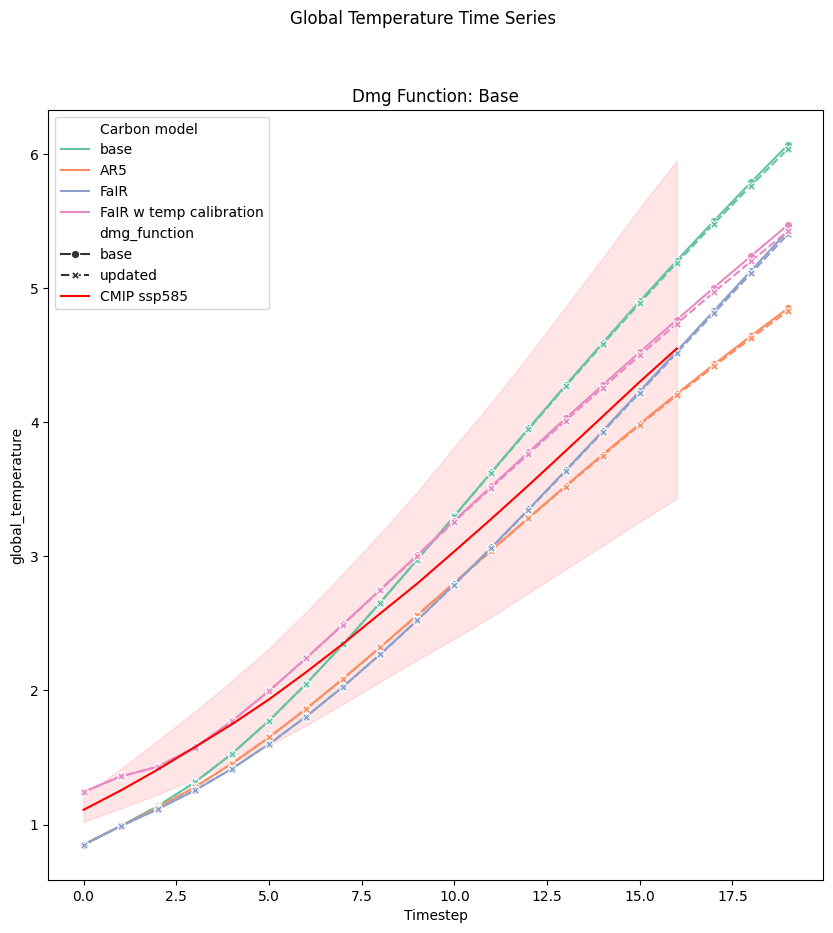

In [7]:
sns.set_palette("Set2")

scenario = 'ssp585'
# Get the temperature pathway from CMIP including mean, upper and lower
tas_mean, tas_lower, tas_upper = CMIP[scenario]

results_data= pd.DataFrame(all_results)
results_data.loc[results_data["temperature_calibration"] == "FaIR", "Carbon model"] = "FaIR w temp calibration"

df = results_data[(results_data['Variable'] == 'global_temperature') & (results_data['Mitigation rate'] == 0)]
df = df.rename(columns={'Value': 'global_temperature'})

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharex=True)

sns.lineplot(data=df, x='Timestep', y='global_temperature', hue='Carbon model',
             markers=True, dashes=True, ax=axes, style='dmg_function')
axes.set_title('Dmg Function: base')

# plot 
axes.plot(tas_mean, color="red", linestyle="-")
axes.fill_between(range(len(tas_mean)), tas_lower, tas_upper, alpha=0.1, color="red")

# add label to legend
handles, labels = axes.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color="red", linestyle="-"))
labels.append(f"CMIP {scenario}")
axes.legend(handles, labels)

# Set common x-axis label
fig.suptitle('Global Temperature Time Series')

# Show the plots
plt.show()